In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import time
from random import randrange
import pretty_midi
import torch.nn.init as init

In [2]:
def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])

    return torch.cat((x, y2),1)

def conv_prev_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = x.shape
    y_shapes = y.shape
    if x_shapes[2:] == y_shapes[2:]:
        y2 = y.expand(x_shapes[0],y_shapes[1],x_shapes[2],x_shapes[3])

        return torch.cat((x, y2),1)

    else:
        print(x_shapes[2:])
        print(y_shapes[2:])


def sigmoid_cross_entropy_with_logits(inputs,labels):
    loss = nn.BCEWithLogitsLoss()
    output = loss(inputs, labels)
    return output



def reduce_mean(x):
    output = torch.mean(x,0, keepdim = False)
    output = torch.mean(output,-1, keepdim = False)
    return output


def reduce_mean_0(x):
    output = torch.mean(x,0, keepdim = False)
    return output


def l2_loss(x,y):
    loss_ = nn.MSELoss(reduction='sum')
    l2_loss_ = loss_(x, y)/2
    return l2_loss_


def lrelu(x, leak=0.2):
    z = torch.mul(x,leak)
    return torch.max(x, z)

def generate_and_save_images(model, epoch, z, prev):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    model.eval()
    #print(z.shape)
    #print(prev.shape)
    with torch.no_grad():
        bar = model(z, prev).detach().cpu().numpy().squeeze().transpose()

    plt.imshow(bar)
    plt.colorbar()
    plt.title('Piano Roll Visualization')
    plt.xlabel('time')
    plt.ylabel('Note (MIDI Number)')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    model.train()

def print_piano_roll(piano_roll):
    plt.imshow(piano_roll)
    plt.colorbar()
    plt.title('Piano Roll Visualization')
    plt.xlabel('time')
    plt.ylabel('Note (MIDI Number)')
    plt.show()


class MinibatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.kernel_dims = kernel_dims

        self.T = nn.Parameter(torch.Tensor(in_features, out_features, kernel_dims))
        init.normal_(self.T, 0, 1)

    def forward(self, x):
        # x is NxA
        # T is AxBxC
        matrices = x.mm(self.T.view(self.in_features, -1))
        matrices = matrices.view(-1, self.out_features, self.kernel_dims)

        M = matrices.unsqueeze(0)  # 1xNxBxC
        M_T = M.permute(1, 0, 2, 3)  # Nx1xBxC
        norm = torch.abs(M - M_T).sum(3)  # NxNxB
        expnorm = torch.exp(-norm)
        o_b = (expnorm.sum(0) - 1)   # NxB, subtract self distance

        x = torch.cat([x, o_b], 1)
        return x

In [3]:
# custom layer for convolutions with batch normalization and lrelu activation
class ConvolutionLayer2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel, stride, padding):
        super(ConvolutionLayer2d, self).__init__()
        self.conv = nn.Conv2d(channels_in, channels_out, kernel, stride, padding, bias = False)
        self.batch_norm = nn.BatchNorm2d(channels_out)
        self.instance_norm = nn.InstanceNorm2d(channels_out)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace = False)
    
    def forward(self,x, normalize=None, activation = True):
        x = self.conv(x)
        if normalize == "batch":
            x = self.batch_norm(x)
        if normalize == "instance":
            x = self.instance_norm(x)
        if activation:
            x = self.leaky_relu(x)
        return x
    
    @property
    def weight(self):
        return self.conv.weight

    @property
    def bias(self):
        return self.conv.bias

# custom layer for transposed convolutions with batch normalization and relu activation
class ConvolutionTransposeLayer2d(nn.Module):
    def __init__(self, channels_in, channels_out, kernel, stride, padding):
        super(ConvolutionTransposeLayer2d, self).__init__()
        self.conv = nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding, bias = False)
        self.batch_norm = nn.BatchNorm2d(channels_out)
        self.instance_norm = nn.InstanceNorm2d(channels_out)
        self.relu = nn.ReLU(inplace = False)
    
    def forward(self, x, normalize=None, activation=None):
        x = self.conv(x)
        if normalize == "batch":
            x = self.batch_norm(x)
        if normalize == "instance":
            x = self.instance_norm(x)

        # Apply custom activation if provided, otherwise use ReLU by default
        if activation is not None:
            x = activation(x)
        else:
            x = self.relu(x)
        return x
    
    @property
    def weight(self):
        return self.conv.weight

    @property
    def bias(self):
        return self.conv.bias

# linear layer with batch normalization and relu activation for generator
class LinearLayer(nn.Module):
    def __init__(self, linear_in, linear_out):
        super(LinearLayer, self).__init__()
        self.linear = nn.Linear(linear_in, linear_out)
        self.batch_norm = nn.BatchNorm1d(linear_out)
        self.instance_norm = nn.InstanceNorm1d(linear_out)
        self.relu =  nn.ReLU()
    
    def forward(self, x, normalize = None):
        x = self.linear(x)
        if normalize == "batch":
            x = self.batch_norm(x)
        if normalize == "instance":
            x = self.instance_norm(x)
        x = self.relu(x)
        return x
    
    @property
    def weight(self):
        return self.linear.weight

    @property
    def bias(self):
        return self.linear.bias

In [4]:
'''
class Generator(nn.Module):
    def __init__(self, nz=100, pitches=128):
        super(Generator,self).__init__()
        self.nz = nz
        self.pitches = pitches
        self.filters_number = 128
        self.filters_number_conditioner = 8
        self.transpose_filters_number = 136
        
        self.linear0 = LinearLayer(nz, 1024)
        self.linear1 = LinearLayer(1024,512)
        
        # Generator transposed convolutions layers
        self.hidden0 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(10,1), stride=2, padding=0)
        self.hidden1 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(2,1), stride=2, padding=0)
        self.hidden2 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out= self.filters_number, kernel=(2,1), stride=2, padding=0)
        self.hidden3 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=1, kernel=(1,pitches), stride=(1,2), padding=0)
        
        # Conditioner convolution layers
        self.condition_hidden0 = ConvolutionLayer2d(channels_in=1, channels_out=self.filters_number_conditioner, kernel=(1,128), stride=(1,2), padding=0)
        self.condition_hidden1 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(2,1), stride=2, padding=0)
        self.condition_hidden2 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(2,1), stride=2, padding=0)
        self.condition_hidden3 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(10,1), stride=2, padding=0)

        self.dropout = nn.Dropout(p=0.5)

         # Additional layer to transform z
        #self.z_transform = nn.Linear(nz, 32*128)  # Adjust the output size based on your architecture
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
            
    def forward(self, z, prev_x):
        batch_size = prev_x.shape[0]
        
        condition_hidden0 = self.condition_hidden0(prev_x, normalize = "batch")
        #condition_hidden0 = self.dropout(condition_hidden0)

        condition_hidden1 = self.condition_hidden1(condition_hidden0, normalize = "batch")
        #condition_hidden1 = self.dropout(condition_hidden1)

        condition_hidden2 = self.condition_hidden2(condition_hidden1, normalize = "batch")
       # condition_hidden2 = self.dropout(condition_hidden2)

        condition_hidden3 = self.condition_hidden3(condition_hidden2, normalize = "batch")
        #condition_hidden3 = self.dropout(condition_hidden3)
        
        z = z.view(batch_size,-1)

       # Transform z to match the shape of h4
        #z_transformed = self.z_transform(z).view(batch_size, 128, 32, 1)  # Adjust shape to match h4
        
        h0 = self.linear0(z, normalize = "batch")
        h1 = self.linear1(h0, normalize = "batch")
        
        h1 = h1.view(batch_size, 128, 4, 1)
        h1 = conv_prev_concat(h1, condition_hidden3)

        h2 = self.hidden0(h1, normalize = "batch")
        h2 = conv_prev_concat(h2, condition_hidden2)
        
        h3 = self.hidden1(h2, normalize = "batch")
        h3 = conv_prev_concat(h3, condition_hidden1)
        
        h4 = self.hidden2(h3, normalize = "batch")#+z_transformed)
        h4 = conv_prev_concat(h4, condition_hidden0)
        
        #x = self.hidden3(h4, normalize=False, activation=nn.Sigmoid())
        x = self.hidden3(h4, activation=nn.Tanh())
                
        return x
        
# discriminator
class Discriminator(nn.Module):

    def __init__(self, pitches=128):
        super(Discriminator,self).__init__()
        self.pitches = pitches
        self.linear_in = 1232
        self.minibatch_features = 0
        
        self.hidden0 = ConvolutionLayer2d(channels_in=1, channels_out=32, kernel=(2,128), stride=2, padding=0)
        self.hidden1 = ConvolutionLayer2d(channels_in=32, channels_out=77, kernel=(2,1), stride=2, padding=0)
        #self.hidden2 = ConvolutionLayer2d(channels_in=64, channels_out=64, kernel=(2,1), stride=2, padding=0)
        #self.hidden3 = ConvolutionLayer2d(channels_in=64, channels_out=77, kernel=(2,1), stride=2, padding=0)
        self.linear = nn.Linear(self.linear_in, 1024)
        self.linear2 = nn.Linear(1024+self.minibatch_features,1)
        self.sigmoid = nn.Sigmoid()
        self.lrelu = nn.LeakyReLU()

        # Minibatch Discrimination layer
        self.minibatch_discrimination = MinibatchDiscrimination(1024, self.minibatch_features, kernel_dims=64)

        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = self.hidden0(x, normalize = "instance")
        fm = h0
        h1 = self.hidden1(h0, normalize = "instance", activation = False)
        #h2 = self.hidden2(h1, normalize = "instance")
        #h3 = self.hidden3(h2, normalize = "instance")
        #h1 = h1.view(batch_size,-1)
        #l = self.linear(h1)
        #l = self.lrelu(l)

        # Minibatch discrimination
        #minibatch_features = self.minibatch_discrimination(l)

        # Concatenate original features with minibatch discrimination features
        #l = torch.cat([l, minibatch_features], dim=1)

        #out = self.linear2(l)
        #out_sigmoid = self.sigmoid(out)
        #return out_sigmoid, out, fm
        return h1  

'''

'\nclass Generator(nn.Module):\n    def __init__(self, nz=100, pitches=128):\n        super(Generator,self).__init__()\n        self.nz = nz\n        self.pitches = pitches\n        self.filters_number = 128\n        self.filters_number_conditioner = 8\n        self.transpose_filters_number = 136\n        \n        self.linear0 = LinearLayer(nz, 1024)\n        self.linear1 = LinearLayer(1024,512)\n        \n        # Generator transposed convolutions layers\n        self.hidden0 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(10,1), stride=2, padding=0)\n        self.hidden1 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(2,1), stride=2, padding=0)\n        self.hidden2 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out= self.filters_number, kernel=(2,1), stride=2, padding=0)\n        self.hidden3 = ConvolutionTransp

### MODEL

In [5]:
'''
class generator(nn.Module):
    def __init__(self,pitch_range):
        super(generator, self).__init__()
        self.gf_dim   = 64
        self.n_channel = 512

        self.h1      = nn.ConvTranspose2d(in_channels=256, out_channels=pitch_range, kernel_size=(10,1), stride=(2,2))
        self.h2      = nn.ConvTranspose2d(in_channels=256, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h3      = nn.ConvTranspose2d(in_channels=256, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))
        self.h4      = nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=(1,pitch_range), stride=(1,2))

        self.h0_prev = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(1,pitch_range), stride=(1,2))
        self.h1_prev = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2,1), stride=(2,2))
        self.h2_prev = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2,1), stride=(2,2))
        self.h3_prev = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(10,1), stride=(2,2))

        self.linear1 = nn.Linear(100,1024)
        self.linear2 = nn.Linear(1024,self.gf_dim*2*2*2)

        self.BN_l1 = nn.BatchNorm1d(1024, momentum=0.9)
        self.BN_l2 = nn.BatchNorm1d(self.gf_dim*2*2*2, momentum=0.9)

        self.BN_h1 = nn.BatchNorm2d(128, momentum=0.9, affine = True)
        self.BN_h2 = nn.BatchNorm2d(128, momentum=0.9, affine=True)
        self.BN_h3 = nn.BatchNorm2d(128, momentum=0.9, affine=True)
    
        self.BN_h0_prev = nn.BatchNorm2d(128, momentum=0.9, affine = True)
        self.BN_h1_prev = nn.BatchNorm2d(128, momentum=0.9, affine = True)
        self.BN_h2_prev = nn.BatchNorm2d(128, momentum=0.9, affine = True)
        self.BN_h3_prev = nn.BatchNorm2d(128, momentum=0.9, affine = True)

    def forward(self, z, prev_x, batch_size):

        h0_prev = lrelu(self.BN_h0_prev(self.h0_prev(prev_x)),0.2)   #[72, 128, 64, 1]
        h1_prev = lrelu(self.BN_h1_prev(self.h1_prev(h0_prev)),0.2)  #[72, 128, 32, 1]
        h2_prev = lrelu(self.BN_h2_prev(self.h2_prev(h1_prev)),0.2)  #[72, 128, 16, 1]
        h3_prev = lrelu(self.BN_h3_prev(self.h3_prev(h2_prev)),0.2)  #[72, 128, 4, 1])

        #z = z         #(72,100)

        h0 = F.relu(self.BN_l1(self.linear1(z)))    #(72,1024)
        h1 = F.relu(self.BN_l2(self.linear2(h0)))   #(72, 512)
        h1 = h1.view(batch_size,self.gf_dim * 2, 4, 1)     #(72,128,4,1)
        
    
        h1 = conv_prev_concat(h1,h3_prev)  #(72, 256, 4, 1)

        h2 = F.relu(self.BN_h1(self.h1(h1)))  #(72, 128, 16, 1)
        h2 = conv_prev_concat(h2,h2_prev)  #([72, 256, 16, 1])

        h3 = F.relu(self.BN_h2(self.h2(h2)))  #([72, 128, 32, 1])
        h3 = conv_prev_concat(h3,h1_prev) #([72, 256, 32, 1])

        h4 = F.relu(self.BN_h3(self.h3(h3)))  #([72, 128, 64, 1])
        h4 = conv_prev_concat(h4,h0_prev) #([72, 256, 64, 1])

        #g_x = torch.sigmoid(self.h4(h4)) #([72, 1, 64, 128])

        g_x = torch.tanh(self.h4(h4))
    
        return g_x


class discriminator(nn.Module):
    def __init__(self, pitch_range):
        super(discriminator, self).__init__()

        self.df_dim = 64
        self.dfc_dim = 1024

        # Convolutional layers
        self.h0 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(2, pitch_range), stride=(2, 2))
        self.h1 = nn.Conv2d(64, 77, kernel_size=(2, 1), stride=(2, 2))

        # Fully connected layers
        self.linear1 = nn.Linear(1232, self.dfc_dim)
        self.linear2 = nn.Linear(self.dfc_dim, 1)

        self.BN_h1 = nn.InstanceNorm2d(77, affine=True)

        self.BN_l1 = nn.InstanceNorm1d(self.dfc_dim)

        

    def forward(self, x, batch_size):
        # x: (72, 1, 64, 128)

        h0 = lrelu(self.h0(x), 0.2)  # (72, 64, 32, 1)

        fm = h0
       
        h1 = lrelu(self.BN_h1(self.h1(h0)), 0.2)  # (72, 77, 16, 1)
        
        # Flatten the output for the fully connected layer
        h1 = h1.view(batch_size, -1)  # (72, 1232)
        h2 = lrelu(self.BN_l1(self.linear1(h1)), 0.2)  # (72, 1024)
        h3 = self.linear2(h2)  # (72, 1)

        #h3_sigmoid = torch.sigmoid(h3)  # Output: (72, 1)
       
        #return h3_sigmoid, h3, fm
        return h3
        '''

'\nclass generator(nn.Module):\n    def __init__(self,pitch_range):\n        super(generator, self).__init__()\n        self.gf_dim   = 64\n        self.n_channel = 512\n\n        self.h1      = nn.ConvTranspose2d(in_channels=256, out_channels=pitch_range, kernel_size=(10,1), stride=(2,2))\n        self.h2      = nn.ConvTranspose2d(in_channels=256, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))\n        self.h3      = nn.ConvTranspose2d(in_channels=256, out_channels=pitch_range, kernel_size=(2,1), stride=(2,2))\n        self.h4      = nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=(1,pitch_range), stride=(1,2))\n\n        self.h0_prev = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(1,pitch_range), stride=(1,2))\n        self.h1_prev = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2,1), stride=(2,2))\n        self.h2_prev = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(2,1), stride=(2,2))\n        self.h3_prev = nn.Conv2d(in

In [6]:
class Generator(nn.Module):
    def __init__(self, nz=100, pitches=128):
        super(Generator,self).__init__()
        self.nz = nz
        self.pitches = pitches
        self.filters_number = 128
        self.filters_number_conditioner = 128
        self.transpose_filters_number = 256
        
        self.linear0 = LinearLayer(nz, 1024)
        self.linear1 = LinearLayer(1024,512)
        
        # Generator transposed convolutions layers
        self.hidden0 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(10,1), stride=2, padding=0)
        self.hidden1 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=self.filters_number, kernel=(2,1), stride=2, padding=0)
        self.hidden2 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out= self.filters_number, kernel=(2,1), stride=2, padding=0)
        self.hidden3 = ConvolutionTransposeLayer2d(channels_in= self.transpose_filters_number, channels_out=1, kernel=(1,pitches), stride=(1,2), padding=0)
        
        # Conditioner convolution layers
        self.condition_hidden0 = ConvolutionLayer2d(channels_in=1, channels_out=self.filters_number_conditioner, kernel=(1,128), stride=(1,2), padding=0)
        self.condition_hidden1 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(2,1), stride=2, padding=0)
        self.condition_hidden2 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(2,1), stride=2, padding=0)
        self.condition_hidden3 = ConvolutionLayer2d(channels_in=self.filters_number_conditioner, channels_out=self.filters_number_conditioner, kernel=(10,1), stride=2, padding=0)

        self.dropout = nn.Dropout(p=0.5)
        
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, z, prev_x):
        batch_size = prev_x.shape[0]

        
        condition_hidden0 = self.condition_hidden0(prev_x, normalize = "batch")
        condition_hidden1 = self.condition_hidden1(condition_hidden0, normalize = "batch")
        condition_hidden2 = self.condition_hidden2(condition_hidden1, normalize = "batch")
        condition_hidden3 = self.condition_hidden3(condition_hidden2, normalize = "batch")
        
        z = z.view(batch_size,-1)
        
        h0 = self.linear0(z, normalize = "batch")
        h1 = self.linear1(h0, normalize = "batch")
        
        h1 = h1.view(batch_size, 128, 4, 1)
        h1 = conv_prev_concat(h1, condition_hidden3)

        h2 = self.hidden0(h1, normalize = "batch")
        h2 = conv_prev_concat(h2, condition_hidden2)
        
        h3 = self.hidden1(h2, normalize = "batch")
        h3 = conv_prev_concat(h3, condition_hidden1)
        
        h4 = self.hidden2(h3, normalize = "batch")
        h4 = conv_prev_concat(h4, condition_hidden0)
        
        x = self.hidden3(h4, activation=nn.Tanh())
                
        return x
    
    # discriminator
class Discriminator(nn.Module):

    def __init__(self, pitches=128):
        super(Discriminator,self).__init__()
        self.pitches = pitches
        self.linear_in = 1232
        
        self.hidden0 = ConvolutionLayer2d(channels_in=1, channels_out=32, kernel=(2,128), stride=2, padding=0)
        self.hidden1 = ConvolutionLayer2d(channels_in=32, channels_out=77, kernel=(2,1), stride=2, padding=0)
        #self.hidden2 = ConvolutionLayer2d(channels_in=24, channels_out=24, kernel=(2,1), stride=2, padding=0)
        self.linear = nn.Linear(self.linear_in, 1024)
        self.linear2 = nn.Linear(1024,1)
        self.sigmoid = nn.Sigmoid()
        self.lrelu = nn.LeakyReLU()

        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = self.hidden0(x)
        fm = h0
        h1 = self.hidden1(h0, normalize = "instance")
        h1 = h1.view(batch_size,-1)
        l = self.linear(h1)
        l = self.lrelu(l)

        out = self.linear2(l)
        #out_sigmoid = self.sigmoid(out)
        #return out_sigmoid, out, fm
        return out

### model initialization

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

### Training

Dataset loading


In [8]:
class MIDI_dataset(Dataset):
    def __init__(self, X_tr_path, prev_X_tr_path, transform = None):

        self.data = np.load(X_tr_path,mmap_mode='r')
        self.prev_data = np.load(prev_X_tr_path,mmap_mode='r')
        self.data_size = self.data.shape[0]
        self.transform = transform

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):

      sample_x = torch.tensor(self.data[index]).float()
      sample_prev_x = torch.tensor(self.prev_data[index]).float()

    
       # Apply the transformation if provided
      if self.transform:
            sample_prev_x = self.transform(sample_prev_x)
            sample_x = sample_x.transpose(1,2)
            sample_prev_x = sample_prev_x.transpose(1,2)
            
        
      else:
          sample_x = sample_x.transpose(1,2)
          sample_prev_x = sample_prev_x.transpose(1,2)
      '''
      if self.transform:
          
          casual = np.random.randint(0, 4)
          if index >=4:
              sample_prev_x = torch.tensor(self.prev_data[index-casual]).float().transpose(1, 2)
      '''

      return sample_x, sample_prev_x
    
# Define your octave shifting transformation
class OctaveShift:
    def __init__(self, octave_shift_range=(-1, 1)):
        self.octave_shift_range = octave_shift_range

    def __call__(self, piano_roll):
        octave_shift = np.random.randint(self.octave_shift_range[0], self.octave_shift_range[1] + 1)
        if octave_shift == 0:
            return piano_roll
        elif octave_shift == 1:
            # Shift up (move rows up by 12, pad with zeros at the bottom)
            shifted_roll = np.roll(piano_roll, -12, axis=0)
            #shifted_roll[-12:, :] = 0  # Zero out the bottom rows
            shifted_roll[-12:, :] = 0

        elif octave_shift == -1:
            # Shift down (move rows down by 12, pad with zeros at the top)
            shifted_roll = np.roll(piano_roll, 12, axis=0)
            #shifted_roll[:12, :] = 0  # Zero out the top rows
            shifted_roll[:12,:]

        return torch.tensor(shifted_roll).float()
    
class TimeChangeTransform:
    def __init__(self, note_divisions=[16, 8, 4]):
        """
        note_divisions: List of allowed note divisions, representing time step durations
        corresponding to quarter, eighth, and sixteenth notes.
        """
        self.note_divisions = note_divisions
    
    def __call__(self, piano_roll):
        # Identify rows (notes) that contain at least one '1' (active note)
        notes_with_activity = (piano_roll.sum(dim=1) > 0).nonzero(as_tuple=True)[0] # Output: tensor([1, 4, 10, ...])  # Indices of rows with notes
        
        if len(notes_with_activity) == 0:
            # If no notes are active, return the original piano roll unchanged
            return piano_roll
        
        # Randomly select one of the active notes
        random_idx = torch.randint(0, notes_with_activity.shape[0], (1,)).item()
        note_idx = notes_with_activity[random_idx].item()
        note_sequence = piano_roll[note_idx]
        
        # Find where the note is played (consecutive 1's)
        note_onsets = (note_sequence[:-1] == 0) & (note_sequence[1:] == 1)  # Onset of notes
        note_offsets = (note_sequence[:-1] == 1) & (note_sequence[1:] == 0)  # End of notes
        
        # Get all the indices where the note is played
        onsets = torch.where(note_onsets)[0].tolist()
        offsets = torch.where(note_offsets)[0].tolist()

        # Choose a random note instance to modify
        if len(onsets) > 0 and len(offsets) > 0:
            idx = np.random.randint(0, len(onsets))
            start = onsets[idx]
            end = offsets[idx]
            
            # Randomly select a new note duration based on rhythmic divisions
            new_duration = np.random.choice(self.note_divisions)
            
            # Modify the note's duration, ensuring it doesn't exceed the bounds of the piano roll
            new_end = min(start + new_duration, 63)  # Clip to stay within the time bounds
            
            # Adjust the piano roll to reflect the new duration
            piano_roll[note_idx, start:new_end] = 1
            if new_end < end:  # Shorten note if necessary
                piano_roll[note_idx, new_end:end] = 0
        
        return piano_roll

composed_transform = torchvision.transforms.Compose([
    TimeChangeTransform(note_divisions=[16, 8, 4]),  # First transformation: time change
    OctaveShift(octave_shift_range=(-1, 1))         # Second transformation: octave shifting
])


In [9]:
X_tr_path = 'X_tr_aug.npy'
prev_X_tr_path = 'prev_X_tr_aug.npy'

octave_transform = OctaveShift(octave_shift_range=(-1, 1))

train_iter = MIDI_dataset(X_tr_path,prev_X_tr_path, transform=composed_transform)
kwargs = {'num_workers': 0, 'pin_memory': True}# if args.cuda else {}
train_loader = DataLoader(train_iter, batch_size=72, shuffle=True, drop_last=True, **kwargs)

Training loop

In [10]:
def gradient_penalty(critic, real, fake, device="cuda"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

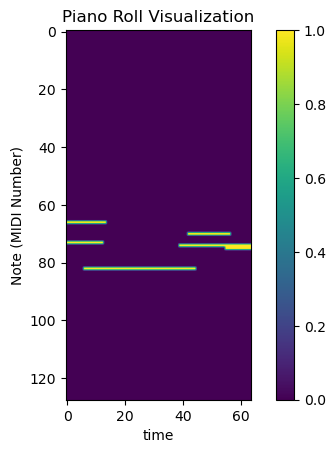

c:\Users\gabro\anaconda3\envs\cuda_test\lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/50] Batch 100/990                   Loss D: -1.5937, loss G: -0.4341
Epoch [0/50] Batch 200/990                   Loss D: -2.2391, loss G: -0.5258
Epoch [0/50] Batch 300/990                   Loss D: -1.8567, loss G: -0.0361
Epoch [0/50] Batch 400/990                   Loss D: -2.1928, loss G: 0.3242
Epoch [0/50] Batch 500/990                   Loss D: -2.2298, loss G: -0.1314
Epoch [0/50] Batch 600/990                   Loss D: -2.1774, loss G: 0.0256
Epoch [0/50] Batch 700/990                   Loss D: -2.0522, loss G: 0.1298
Epoch [0/50] Batch 800/990                   Loss D: -2.1322, loss G: 0.0067
Epoch [0/50] Batch 900/990                   Loss D: -2.1440, loss G: -0.0450


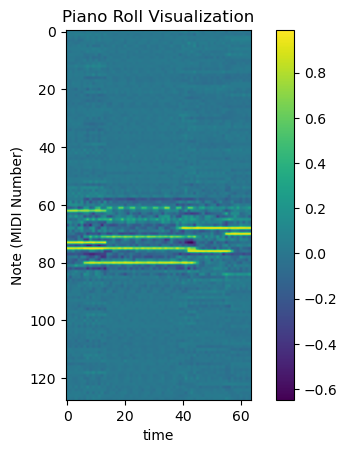

Epoch [1/50] Batch 100/990                   Loss D: -2.1917, loss G: -0.2138
Epoch [1/50] Batch 200/990                   Loss D: -1.8442, loss G: 0.0541
Epoch [1/50] Batch 300/990                   Loss D: -1.9403, loss G: -0.6106
Epoch [1/50] Batch 400/990                   Loss D: -1.6040, loss G: -0.3820
Epoch [1/50] Batch 500/990                   Loss D: -1.9748, loss G: -0.1765
Epoch [1/50] Batch 600/990                   Loss D: -1.5986, loss G: 0.0133
Epoch [1/50] Batch 700/990                   Loss D: -1.7432, loss G: -0.1487
Epoch [1/50] Batch 800/990                   Loss D: -1.5715, loss G: 0.1590
Epoch [1/50] Batch 900/990                   Loss D: -1.8636, loss G: -0.5314


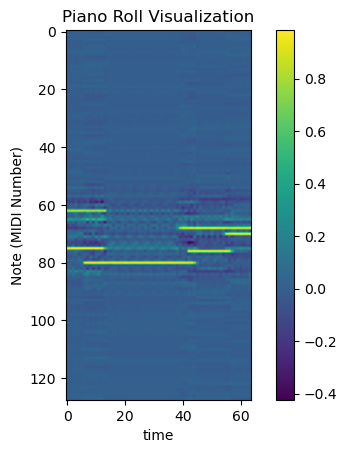

Epoch [2/50] Batch 100/990                   Loss D: -1.7739, loss G: -0.2543
Epoch [2/50] Batch 200/990                   Loss D: -1.7921, loss G: -0.3610
Epoch [2/50] Batch 300/990                   Loss D: -1.7670, loss G: -0.1813
Epoch [2/50] Batch 400/990                   Loss D: -1.4463, loss G: -0.2177
Epoch [2/50] Batch 500/990                   Loss D: -1.3596, loss G: -0.0384
Epoch [2/50] Batch 600/990                   Loss D: -1.4929, loss G: -0.1874
Epoch [2/50] Batch 700/990                   Loss D: -1.7007, loss G: -0.1787
Epoch [2/50] Batch 800/990                   Loss D: -1.3311, loss G: -0.2992
Epoch [2/50] Batch 900/990                   Loss D: -1.8153, loss G: -0.6156


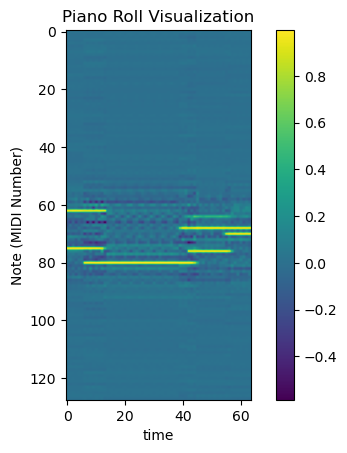

Epoch [3/50] Batch 100/990                   Loss D: -1.4160, loss G: -0.5433
Epoch [3/50] Batch 200/990                   Loss D: -1.7104, loss G: -0.3915
Epoch [3/50] Batch 300/990                   Loss D: -1.4359, loss G: -0.4211
Epoch [3/50] Batch 400/990                   Loss D: -1.6721, loss G: -0.2924
Epoch [3/50] Batch 500/990                   Loss D: -1.6642, loss G: -0.2786
Epoch [3/50] Batch 600/990                   Loss D: -1.4984, loss G: 0.0229
Epoch [3/50] Batch 700/990                   Loss D: -1.5242, loss G: -0.0313
Epoch [3/50] Batch 800/990                   Loss D: -1.4876, loss G: -0.0741
Epoch [3/50] Batch 900/990                   Loss D: -1.6245, loss G: -0.3096


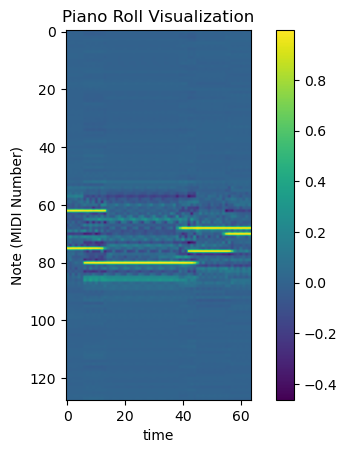

Epoch [4/50] Batch 100/990                   Loss D: -1.6170, loss G: -0.3627
Epoch [4/50] Batch 200/990                   Loss D: -1.5812, loss G: 0.0331
Epoch [4/50] Batch 300/990                   Loss D: -1.7156, loss G: -0.1779
Epoch [4/50] Batch 400/990                   Loss D: -1.9029, loss G: -0.0107
Epoch [4/50] Batch 500/990                   Loss D: -1.8967, loss G: -0.0712
Epoch [4/50] Batch 600/990                   Loss D: -1.3459, loss G: -0.1020
Epoch [4/50] Batch 700/990                   Loss D: -1.6793, loss G: -0.0449
Epoch [4/50] Batch 800/990                   Loss D: -1.4340, loss G: 0.0956
Epoch [4/50] Batch 900/990                   Loss D: -1.4713, loss G: 0.3085


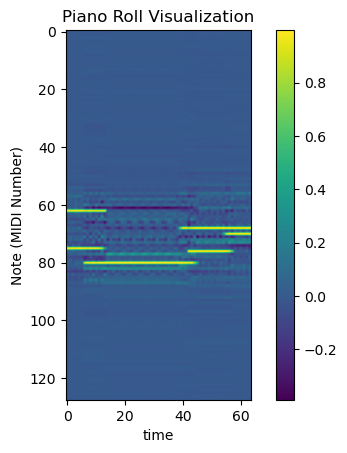

Epoch [5/50] Batch 100/990                   Loss D: -1.5877, loss G: 0.1416
Epoch [5/50] Batch 200/990                   Loss D: -1.5954, loss G: -0.3220
Epoch [5/50] Batch 300/990                   Loss D: -1.5663, loss G: -0.1969
Epoch [5/50] Batch 400/990                   Loss D: -1.6119, loss G: 0.2357
Epoch [5/50] Batch 500/990                   Loss D: -1.3678, loss G: 0.2805
Epoch [5/50] Batch 600/990                   Loss D: -1.5829, loss G: -0.2632
Epoch [5/50] Batch 700/990                   Loss D: -1.7872, loss G: -0.2880
Epoch [5/50] Batch 800/990                   Loss D: -1.6864, loss G: -0.4332
Epoch [5/50] Batch 900/990                   Loss D: -1.5934, loss G: -0.3047


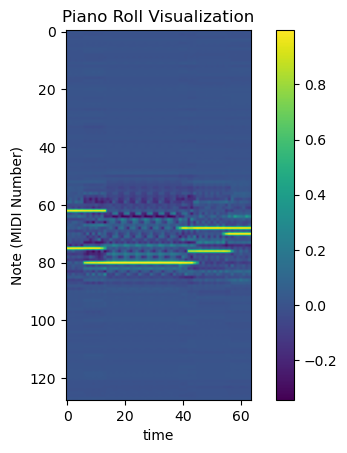

Epoch [6/50] Batch 100/990                   Loss D: -1.7915, loss G: -0.4787
Epoch [6/50] Batch 200/990                   Loss D: -1.4172, loss G: -0.3289
Epoch [6/50] Batch 300/990                   Loss D: -1.5454, loss G: -0.0794
Epoch [6/50] Batch 400/990                   Loss D: -1.3655, loss G: 0.1232
Epoch [6/50] Batch 500/990                   Loss D: -1.4600, loss G: -0.0938
Epoch [6/50] Batch 600/990                   Loss D: -1.4607, loss G: -0.1540
Epoch [6/50] Batch 700/990                   Loss D: -1.5171, loss G: -0.1586
Epoch [6/50] Batch 800/990                   Loss D: -1.4220, loss G: 0.1935
Epoch [6/50] Batch 900/990                   Loss D: -1.4210, loss G: -0.1232


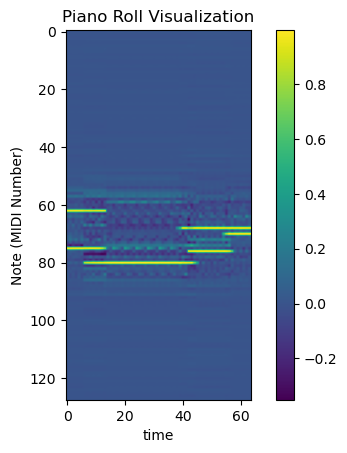

Epoch [7/50] Batch 100/990                   Loss D: -1.4458, loss G: 0.0746
Epoch [7/50] Batch 200/990                   Loss D: -1.5347, loss G: -0.3236
Epoch [7/50] Batch 300/990                   Loss D: -1.2501, loss G: -0.2721
Epoch [7/50] Batch 400/990                   Loss D: -1.2506, loss G: -0.5607
Epoch [7/50] Batch 500/990                   Loss D: -1.5261, loss G: -0.4613
Epoch [7/50] Batch 600/990                   Loss D: -1.6558, loss G: -0.5523
Epoch [7/50] Batch 700/990                   Loss D: -1.1872, loss G: -0.3143
Epoch [7/50] Batch 800/990                   Loss D: -1.0992, loss G: -0.2738
Epoch [7/50] Batch 900/990                   Loss D: -1.2655, loss G: -0.4474


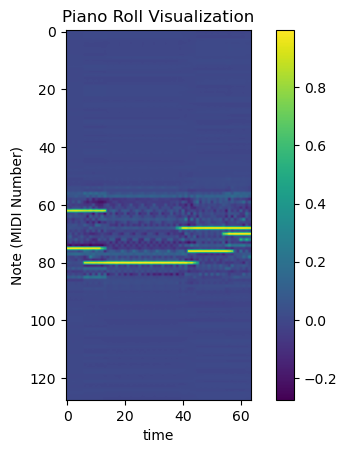

Epoch [8/50] Batch 100/990                   Loss D: -1.1517, loss G: -0.3823
Epoch [8/50] Batch 200/990                   Loss D: -1.3159, loss G: -0.2352
Epoch [8/50] Batch 300/990                   Loss D: -1.4213, loss G: -0.3049
Epoch [8/50] Batch 400/990                   Loss D: -1.4304, loss G: -0.4719
Epoch [8/50] Batch 500/990                   Loss D: -1.3662, loss G: -1.1017
Epoch [8/50] Batch 600/990                   Loss D: -1.2049, loss G: -0.2933
Epoch [8/50] Batch 700/990                   Loss D: -1.3663, loss G: -0.8198
Epoch [8/50] Batch 800/990                   Loss D: -1.1332, loss G: -0.6580
Epoch [8/50] Batch 900/990                   Loss D: -1.0740, loss G: -0.3843


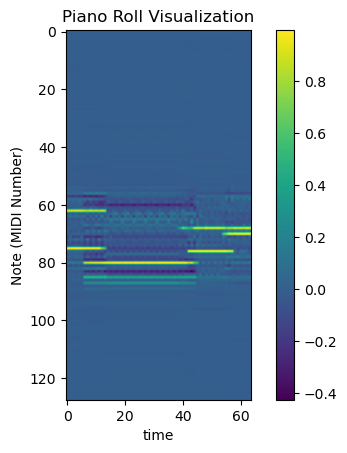

Epoch [9/50] Batch 100/990                   Loss D: -1.3654, loss G: -0.6530
Epoch [9/50] Batch 200/990                   Loss D: -1.3390, loss G: -0.6697
Epoch [9/50] Batch 300/990                   Loss D: -0.9310, loss G: -0.3518
Epoch [9/50] Batch 400/990                   Loss D: -1.1577, loss G: -0.6382
Epoch [9/50] Batch 500/990                   Loss D: -0.9411, loss G: -0.5236
Epoch [9/50] Batch 600/990                   Loss D: -1.0375, loss G: -0.3675
Epoch [9/50] Batch 700/990                   Loss D: -1.0533, loss G: -0.8537
Epoch [9/50] Batch 800/990                   Loss D: -1.2749, loss G: -0.8844
Epoch [9/50] Batch 900/990                   Loss D: -1.0213, loss G: -0.7502


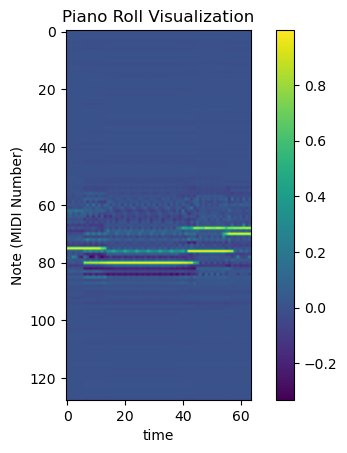

Epoch [10/50] Batch 100/990                   Loss D: -1.0876, loss G: -0.9881
Epoch [10/50] Batch 200/990                   Loss D: -0.9692, loss G: -0.6412
Epoch [10/50] Batch 300/990                   Loss D: -1.0377, loss G: -0.3379
Epoch [10/50] Batch 400/990                   Loss D: -1.0550, loss G: -0.7753
Epoch [10/50] Batch 500/990                   Loss D: -0.8246, loss G: -0.5426
Epoch [10/50] Batch 600/990                   Loss D: -1.1721, loss G: -0.8282
Epoch [10/50] Batch 700/990                   Loss D: -1.0701, loss G: -0.6408
Epoch [10/50] Batch 800/990                   Loss D: -0.8021, loss G: -0.5021
Epoch [10/50] Batch 900/990                   Loss D: -1.0655, loss G: -0.3088


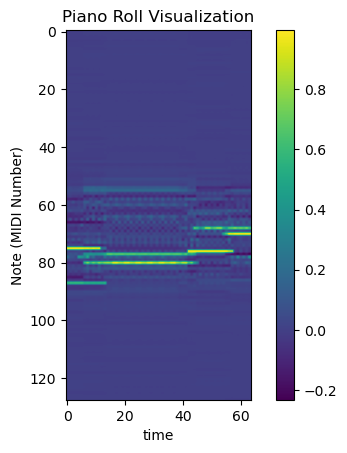

Epoch [11/50] Batch 100/990                   Loss D: -1.0944, loss G: -0.5207
Epoch [11/50] Batch 200/990                   Loss D: -0.7754, loss G: -0.2102
Epoch [11/50] Batch 300/990                   Loss D: -0.9245, loss G: -0.7575
Epoch [11/50] Batch 400/990                   Loss D: -0.8797, loss G: -0.3553
Epoch [11/50] Batch 500/990                   Loss D: -0.8410, loss G: -0.7562
Epoch [11/50] Batch 600/990                   Loss D: -1.0240, loss G: -0.5097
Epoch [11/50] Batch 700/990                   Loss D: -0.9263, loss G: -0.0085
Epoch [11/50] Batch 800/990                   Loss D: -0.9561, loss G: -0.4037
Epoch [11/50] Batch 900/990                   Loss D: -0.9584, loss G: -0.3647


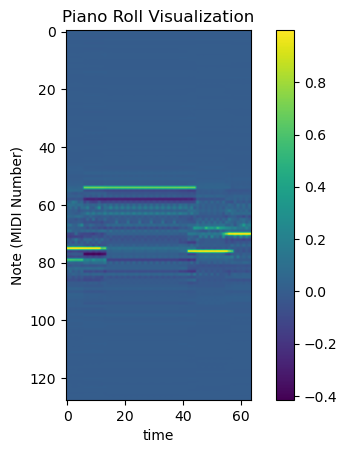

Epoch [12/50] Batch 100/990                   Loss D: -0.8029, loss G: -0.6479
Epoch [12/50] Batch 200/990                   Loss D: -0.8523, loss G: -0.9424
Epoch [12/50] Batch 300/990                   Loss D: -0.9495, loss G: -0.2370
Epoch [12/50] Batch 400/990                   Loss D: -0.6293, loss G: -0.0636
Epoch [12/50] Batch 500/990                   Loss D: -0.9794, loss G: -0.4312
Epoch [12/50] Batch 600/990                   Loss D: -0.9238, loss G: -0.4849
Epoch [12/50] Batch 700/990                   Loss D: -0.9086, loss G: -0.5783
Epoch [12/50] Batch 800/990                   Loss D: -0.5582, loss G: -0.5705
Epoch [12/50] Batch 900/990                   Loss D: -0.8407, loss G: -0.6721


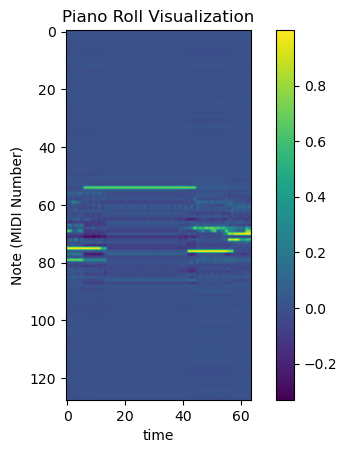

Epoch [13/50] Batch 100/990                   Loss D: -0.8522, loss G: -0.8083
Epoch [13/50] Batch 200/990                   Loss D: -0.9591, loss G: -0.5208
Epoch [13/50] Batch 300/990                   Loss D: -0.7219, loss G: -0.6820
Epoch [13/50] Batch 400/990                   Loss D: -0.6861, loss G: -0.9355
Epoch [13/50] Batch 500/990                   Loss D: -1.0942, loss G: -0.7312
Epoch [13/50] Batch 600/990                   Loss D: -1.0018, loss G: -0.7683
Epoch [13/50] Batch 700/990                   Loss D: -0.8195, loss G: -0.5546
Epoch [13/50] Batch 800/990                   Loss D: -0.8432, loss G: -0.4929
Epoch [13/50] Batch 900/990                   Loss D: -1.0175, loss G: -0.4647


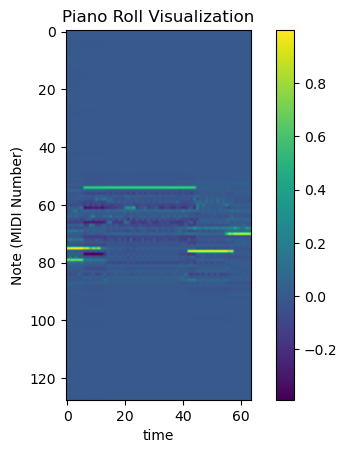

Epoch [14/50] Batch 100/990                   Loss D: -0.6641, loss G: 0.0164
Epoch [14/50] Batch 200/990                   Loss D: -0.7972, loss G: 0.0986
Epoch [14/50] Batch 300/990                   Loss D: -0.7562, loss G: -0.7403
Epoch [14/50] Batch 400/990                   Loss D: -0.9868, loss G: -0.6233
Epoch [14/50] Batch 500/990                   Loss D: -0.8077, loss G: 0.0343
Epoch [14/50] Batch 600/990                   Loss D: -0.7627, loss G: -0.5435
Epoch [14/50] Batch 700/990                   Loss D: -0.6094, loss G: 0.0050
Epoch [14/50] Batch 800/990                   Loss D: -0.8644, loss G: -0.9827
Epoch [14/50] Batch 900/990                   Loss D: -0.8217, loss G: -0.4252


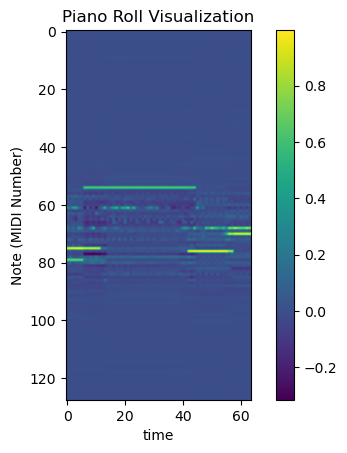

Epoch [15/50] Batch 100/990                   Loss D: -0.7568, loss G: -0.1148
Epoch [15/50] Batch 200/990                   Loss D: -0.9307, loss G: -0.2451
Epoch [15/50] Batch 300/990                   Loss D: -0.7721, loss G: -0.6850
Epoch [15/50] Batch 400/990                   Loss D: -0.7306, loss G: -0.4850
Epoch [15/50] Batch 500/990                   Loss D: -0.9310, loss G: -0.7161
Epoch [15/50] Batch 600/990                   Loss D: -0.8223, loss G: -0.4631
Epoch [15/50] Batch 700/990                   Loss D: -0.8935, loss G: -0.1079
Epoch [15/50] Batch 800/990                   Loss D: -0.5944, loss G: -0.4715
Epoch [15/50] Batch 900/990                   Loss D: -0.5652, loss G: -0.0634


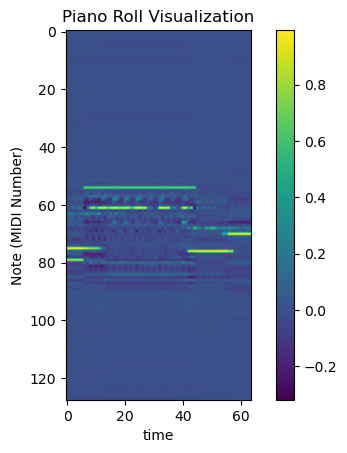

Epoch [16/50] Batch 100/990                   Loss D: -0.7182, loss G: -0.2906
Epoch [16/50] Batch 200/990                   Loss D: -0.7845, loss G: -0.5164
Epoch [16/50] Batch 300/990                   Loss D: -0.9523, loss G: -0.3067
Epoch [16/50] Batch 400/990                   Loss D: -0.6821, loss G: -0.4686
Epoch [16/50] Batch 500/990                   Loss D: -0.9182, loss G: -0.9798
Epoch [16/50] Batch 600/990                   Loss D: -0.9153, loss G: -0.6157
Epoch [16/50] Batch 700/990                   Loss D: -0.8349, loss G: -0.4932
Epoch [16/50] Batch 800/990                   Loss D: -0.9363, loss G: -0.4905
Epoch [16/50] Batch 900/990                   Loss D: -0.6481, loss G: 0.3819


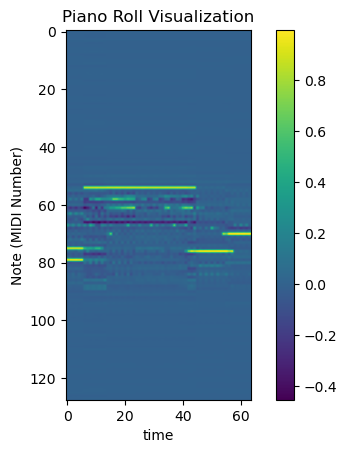

Epoch [17/50] Batch 100/990                   Loss D: -0.7843, loss G: -0.5662
Epoch [17/50] Batch 200/990                   Loss D: -0.6933, loss G: -0.2319
Epoch [17/50] Batch 300/990                   Loss D: -0.7774, loss G: 0.4444
Epoch [17/50] Batch 400/990                   Loss D: -0.7996, loss G: -0.1368
Epoch [17/50] Batch 500/990                   Loss D: -0.5524, loss G: -0.1599
Epoch [17/50] Batch 600/990                   Loss D: -0.8407, loss G: -0.3471
Epoch [17/50] Batch 700/990                   Loss D: -0.7088, loss G: -0.2559
Epoch [17/50] Batch 800/990                   Loss D: -0.8127, loss G: 0.1967
Epoch [17/50] Batch 900/990                   Loss D: -0.8601, loss G: 0.2873


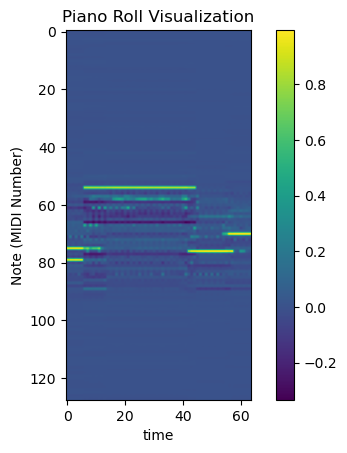

Epoch [18/50] Batch 100/990                   Loss D: -0.8315, loss G: -0.7194
Epoch [18/50] Batch 200/990                   Loss D: -1.0204, loss G: -0.9209
Epoch [18/50] Batch 300/990                   Loss D: -0.6299, loss G: -0.8371
Epoch [18/50] Batch 400/990                   Loss D: -0.6874, loss G: 0.4155
Epoch [18/50] Batch 500/990                   Loss D: -0.7185, loss G: -0.7472
Epoch [18/50] Batch 600/990                   Loss D: -1.0753, loss G: -0.2030
Epoch [18/50] Batch 700/990                   Loss D: -0.8792, loss G: -0.4631
Epoch [18/50] Batch 800/990                   Loss D: -0.9605, loss G: -0.3039
Epoch [18/50] Batch 900/990                   Loss D: -0.6169, loss G: -0.5645


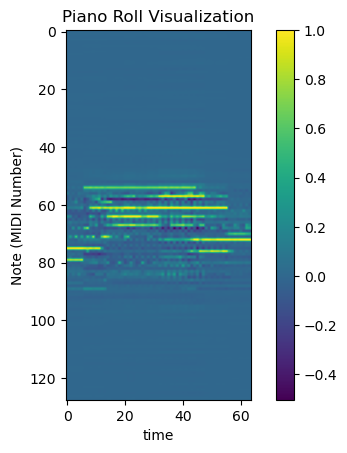

Epoch [19/50] Batch 100/990                   Loss D: -0.6591, loss G: 0.2336
Epoch [19/50] Batch 200/990                   Loss D: -0.6340, loss G: -0.8610
Epoch [19/50] Batch 300/990                   Loss D: -0.9024, loss G: -1.2677
Epoch [19/50] Batch 400/990                   Loss D: -0.9129, loss G: -0.6618
Epoch [19/50] Batch 500/990                   Loss D: -0.6504, loss G: -0.5220
Epoch [19/50] Batch 600/990                   Loss D: -0.6779, loss G: -0.2972
Epoch [19/50] Batch 700/990                   Loss D: -0.7745, loss G: -0.9258
Epoch [19/50] Batch 800/990                   Loss D: -0.6552, loss G: -0.3515
Epoch [19/50] Batch 900/990                   Loss D: -0.5485, loss G: -0.3128


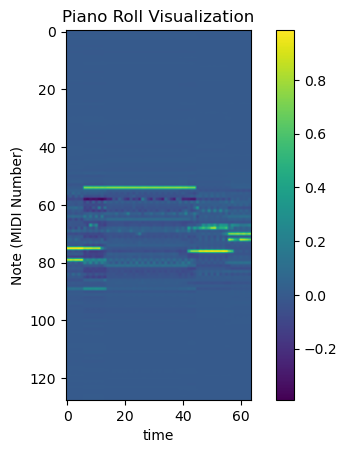

Epoch [20/50] Batch 100/990                   Loss D: -0.8506, loss G: -0.5665
Epoch [20/50] Batch 200/990                   Loss D: -0.6863, loss G: -0.1361
Epoch [20/50] Batch 300/990                   Loss D: -0.7640, loss G: -0.4735
Epoch [20/50] Batch 400/990                   Loss D: -0.7371, loss G: -0.7660
Epoch [20/50] Batch 500/990                   Loss D: -0.4603, loss G: 0.0813
Epoch [20/50] Batch 600/990                   Loss D: -0.9661, loss G: -1.0082
Epoch [20/50] Batch 700/990                   Loss D: -0.9205, loss G: -0.7065
Epoch [20/50] Batch 800/990                   Loss D: -0.6551, loss G: -0.3523
Epoch [20/50] Batch 900/990                   Loss D: -0.8903, loss G: -0.2587


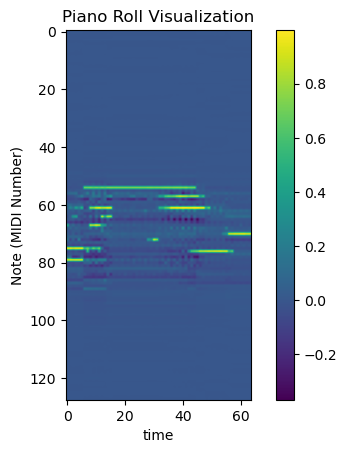

Epoch [21/50] Batch 100/990                   Loss D: -0.6416, loss G: -0.8419
Epoch [21/50] Batch 200/990                   Loss D: -0.8561, loss G: -0.0646
Epoch [21/50] Batch 300/990                   Loss D: -0.6693, loss G: -0.1605
Epoch [21/50] Batch 400/990                   Loss D: -0.5530, loss G: 0.2828
Epoch [21/50] Batch 500/990                   Loss D: -0.6928, loss G: -0.5908
Epoch [21/50] Batch 600/990                   Loss D: -0.5849, loss G: -0.6944
Epoch [21/50] Batch 700/990                   Loss D: -0.6203, loss G: 0.2729
Epoch [21/50] Batch 800/990                   Loss D: -0.6147, loss G: -0.6223
Epoch [21/50] Batch 900/990                   Loss D: -0.6559, loss G: 0.0792


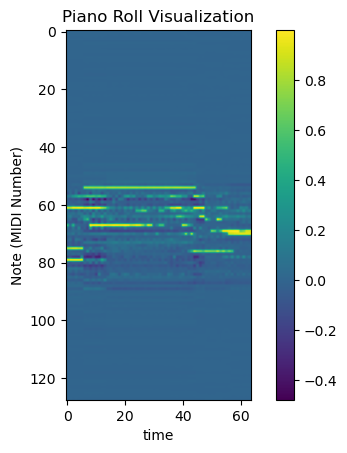

Epoch [22/50] Batch 100/990                   Loss D: -0.5332, loss G: -0.0909
Epoch [22/50] Batch 200/990                   Loss D: -0.7831, loss G: -0.4461
Epoch [22/50] Batch 300/990                   Loss D: -0.8017, loss G: -0.3110
Epoch [22/50] Batch 400/990                   Loss D: -0.6255, loss G: -0.1910
Epoch [22/50] Batch 500/990                   Loss D: -0.7942, loss G: 0.1532
Epoch [22/50] Batch 600/990                   Loss D: -0.6714, loss G: 0.0372
Epoch [22/50] Batch 700/990                   Loss D: -0.6457, loss G: 0.5609
Epoch [22/50] Batch 800/990                   Loss D: -0.6775, loss G: -0.5344
Epoch [22/50] Batch 900/990                   Loss D: -0.7699, loss G: -0.4891


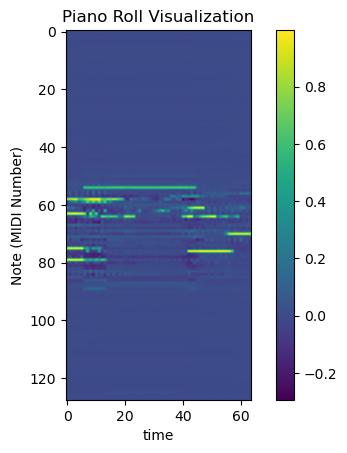

Epoch [23/50] Batch 100/990                   Loss D: -0.8745, loss G: -0.8114
Epoch [23/50] Batch 200/990                   Loss D: -0.9947, loss G: -0.2241
Epoch [23/50] Batch 300/990                   Loss D: -0.6298, loss G: -0.4296
Epoch [23/50] Batch 400/990                   Loss D: -0.7897, loss G: -0.2988
Epoch [23/50] Batch 500/990                   Loss D: -0.8214, loss G: -0.1310
Epoch [23/50] Batch 600/990                   Loss D: -0.8695, loss G: 0.2681
Epoch [23/50] Batch 700/990                   Loss D: -0.5613, loss G: -0.0025
Epoch [23/50] Batch 800/990                   Loss D: -0.7317, loss G: 0.2516
Epoch [23/50] Batch 900/990                   Loss D: -0.9829, loss G: -0.3811


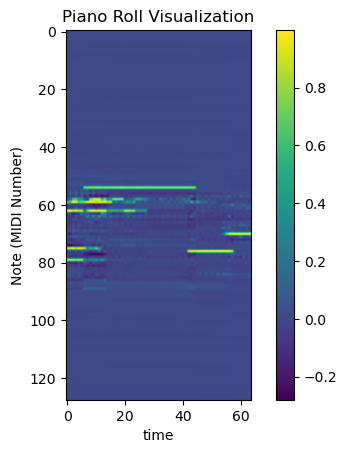

Epoch [24/50] Batch 100/990                   Loss D: -0.5596, loss G: -0.2373
Epoch [24/50] Batch 200/990                   Loss D: -0.7391, loss G: -0.3397
Epoch [24/50] Batch 300/990                   Loss D: -0.7546, loss G: 0.1881
Epoch [24/50] Batch 400/990                   Loss D: -0.7585, loss G: -0.0075
Epoch [24/50] Batch 500/990                   Loss D: -0.9076, loss G: -0.8633
Epoch [24/50] Batch 600/990                   Loss D: -0.7202, loss G: 0.7336
Epoch [24/50] Batch 700/990                   Loss D: -1.0246, loss G: -0.5580
Epoch [24/50] Batch 800/990                   Loss D: -0.6177, loss G: 0.2458
Epoch [24/50] Batch 900/990                   Loss D: -0.8457, loss G: -0.0403


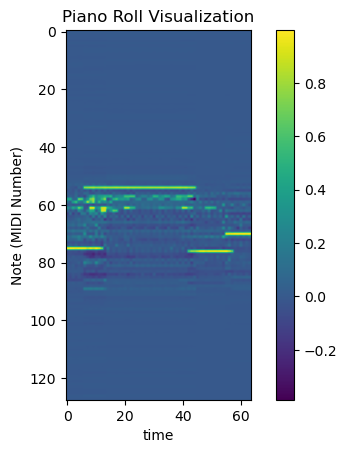

Epoch [25/50] Batch 100/990                   Loss D: -0.5578, loss G: 0.3692
Epoch [25/50] Batch 200/990                   Loss D: -0.8439, loss G: -0.8005
Epoch [25/50] Batch 300/990                   Loss D: -0.6168, loss G: 0.7739
Epoch [25/50] Batch 400/990                   Loss D: -0.7494, loss G: -0.0327
Epoch [25/50] Batch 500/990                   Loss D: -0.6155, loss G: -0.0556
Epoch [25/50] Batch 600/990                   Loss D: -0.8293, loss G: -0.3147
Epoch [25/50] Batch 700/990                   Loss D: -0.8128, loss G: 0.2672
Epoch [25/50] Batch 800/990                   Loss D: -0.7274, loss G: -0.8516
Epoch [25/50] Batch 900/990                   Loss D: -0.7477, loss G: -0.0085


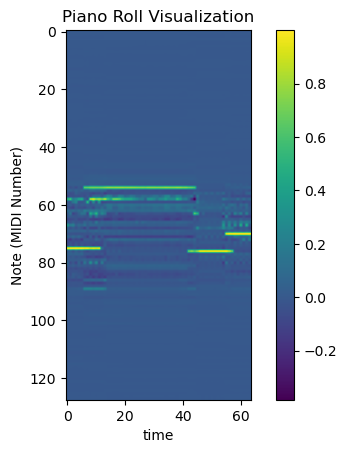

Epoch [26/50] Batch 100/990                   Loss D: -0.7204, loss G: 0.1230
Epoch [26/50] Batch 200/990                   Loss D: -0.6984, loss G: -0.4855
Epoch [26/50] Batch 300/990                   Loss D: -0.7286, loss G: 0.0156
Epoch [26/50] Batch 400/990                   Loss D: -0.7330, loss G: -0.4924
Epoch [26/50] Batch 500/990                   Loss D: -0.9398, loss G: 0.5056
Epoch [26/50] Batch 600/990                   Loss D: -0.5626, loss G: -0.2267
Epoch [26/50] Batch 700/990                   Loss D: -0.4938, loss G: -0.7123
Epoch [26/50] Batch 800/990                   Loss D: -0.8140, loss G: -0.6140
Epoch [26/50] Batch 900/990                   Loss D: -0.6001, loss G: 0.0298


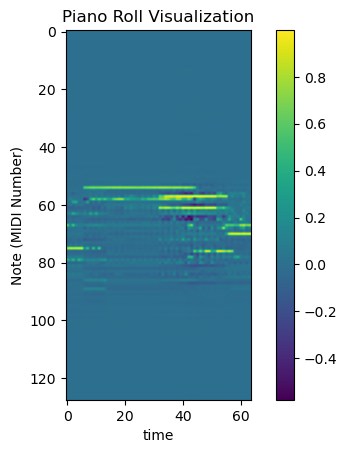

Epoch [27/50] Batch 100/990                   Loss D: -0.6346, loss G: 0.2858
Epoch [27/50] Batch 200/990                   Loss D: -0.8456, loss G: -0.6650
Epoch [27/50] Batch 300/990                   Loss D: -0.8329, loss G: 0.1714
Epoch [27/50] Batch 400/990                   Loss D: -0.6184, loss G: 0.3561
Epoch [27/50] Batch 500/990                   Loss D: -0.6618, loss G: 0.0157
Epoch [27/50] Batch 600/990                   Loss D: -0.6619, loss G: 0.0283
Epoch [27/50] Batch 700/990                   Loss D: -0.7712, loss G: 0.5591
Epoch [27/50] Batch 800/990                   Loss D: -0.5541, loss G: 0.5583
Epoch [27/50] Batch 900/990                   Loss D: -0.7961, loss G: -0.2404


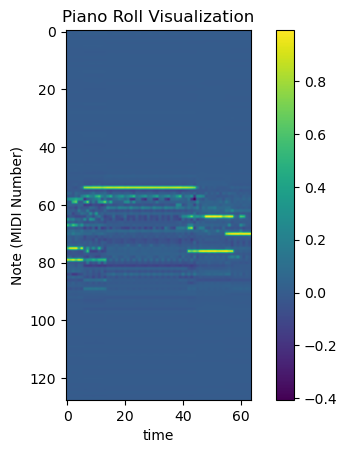

Epoch [28/50] Batch 100/990                   Loss D: -0.5872, loss G: -0.0804
Epoch [28/50] Batch 200/990                   Loss D: -0.6738, loss G: 0.4642
Epoch [28/50] Batch 300/990                   Loss D: -0.7704, loss G: 0.3165
Epoch [28/50] Batch 400/990                   Loss D: -0.4820, loss G: 0.0227
Epoch [28/50] Batch 500/990                   Loss D: -0.6404, loss G: 0.3091
Epoch [28/50] Batch 600/990                   Loss D: -0.6890, loss G: 0.3536
Epoch [28/50] Batch 700/990                   Loss D: -0.6622, loss G: -0.4539
Epoch [28/50] Batch 800/990                   Loss D: -0.6588, loss G: 0.1174
Epoch [28/50] Batch 900/990                   Loss D: -0.6470, loss G: -0.1362


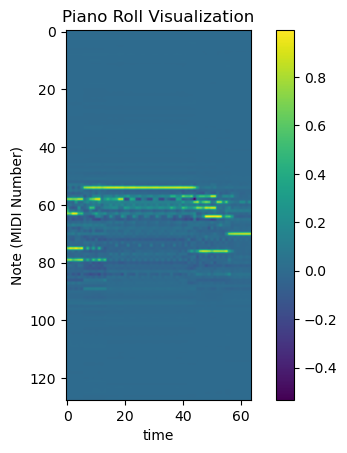

Epoch [29/50] Batch 100/990                   Loss D: -0.4229, loss G: 0.0213
Epoch [29/50] Batch 200/990                   Loss D: -0.5957, loss G: -0.1617
Epoch [29/50] Batch 300/990                   Loss D: -0.5528, loss G: 0.2382
Epoch [29/50] Batch 400/990                   Loss D: -0.6637, loss G: 0.3456
Epoch [29/50] Batch 500/990                   Loss D: -0.5008, loss G: -0.0069
Epoch [29/50] Batch 600/990                   Loss D: -0.5831, loss G: 0.4380
Epoch [29/50] Batch 700/990                   Loss D: -0.5793, loss G: 0.5910
Epoch [29/50] Batch 800/990                   Loss D: -0.5872, loss G: -0.0108
Epoch [29/50] Batch 900/990                   Loss D: -0.5946, loss G: -0.1361


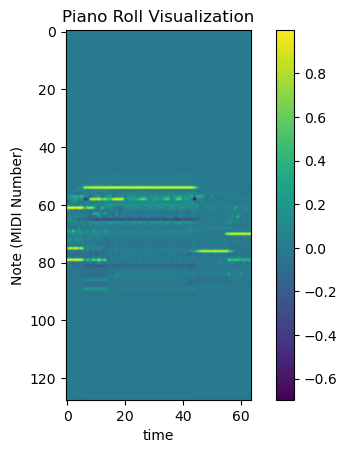

Epoch [30/50] Batch 100/990                   Loss D: -0.6715, loss G: 0.5447
Epoch [30/50] Batch 200/990                   Loss D: -0.6402, loss G: -0.1813
Epoch [30/50] Batch 300/990                   Loss D: -0.6602, loss G: -0.3528
Epoch [30/50] Batch 400/990                   Loss D: -0.7247, loss G: -0.0081
Epoch [30/50] Batch 500/990                   Loss D: -0.8539, loss G: -0.9651
Epoch [30/50] Batch 600/990                   Loss D: -0.6183, loss G: -0.3154
Epoch [30/50] Batch 700/990                   Loss D: -0.6175, loss G: -0.6254
Epoch [30/50] Batch 800/990                   Loss D: -0.7895, loss G: 0.6174
Epoch [30/50] Batch 900/990                   Loss D: -0.5336, loss G: -0.8886


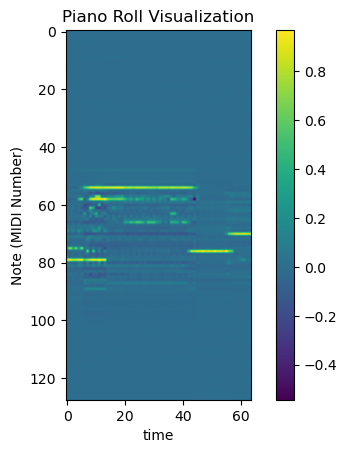

Epoch [31/50] Batch 100/990                   Loss D: -0.6793, loss G: 0.2886
Epoch [31/50] Batch 200/990                   Loss D: -0.7335, loss G: -0.1477
Epoch [31/50] Batch 300/990                   Loss D: -0.6241, loss G: -0.2206
Epoch [31/50] Batch 400/990                   Loss D: -0.4966, loss G: 0.2100
Epoch [31/50] Batch 500/990                   Loss D: -0.7471, loss G: -0.0105
Epoch [31/50] Batch 600/990                   Loss D: -0.5232, loss G: -0.1486
Epoch [31/50] Batch 700/990                   Loss D: -0.7612, loss G: 1.1568
Epoch [31/50] Batch 800/990                   Loss D: -0.5659, loss G: -0.4383
Epoch [31/50] Batch 900/990                   Loss D: -0.3903, loss G: -0.1998


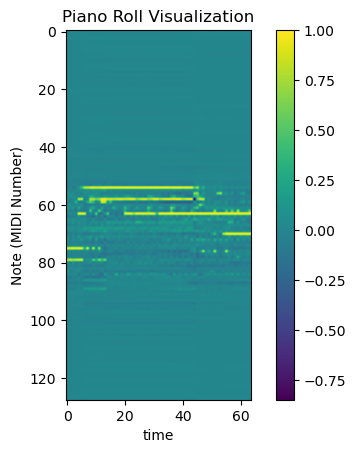

Epoch [32/50] Batch 100/990                   Loss D: -0.5546, loss G: -0.2608
Epoch [32/50] Batch 200/990                   Loss D: -0.6316, loss G: 0.3012
Epoch [32/50] Batch 300/990                   Loss D: -0.8456, loss G: -1.0149
Epoch [32/50] Batch 400/990                   Loss D: -0.6658, loss G: -0.5730
Epoch [32/50] Batch 500/990                   Loss D: -0.3657, loss G: 0.8280
Epoch [32/50] Batch 600/990                   Loss D: -0.5191, loss G: -1.1163
Epoch [32/50] Batch 700/990                   Loss D: -0.7671, loss G: -0.2953
Epoch [32/50] Batch 800/990                   Loss D: -0.5970, loss G: 0.1181
Epoch [32/50] Batch 900/990                   Loss D: -0.6243, loss G: -0.0245


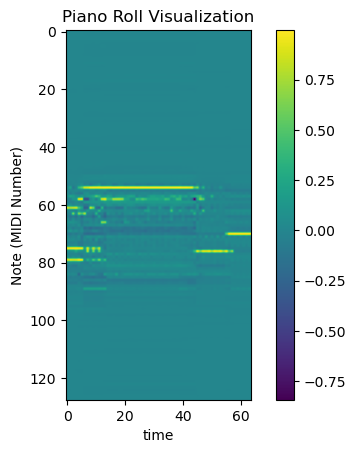

Epoch [33/50] Batch 100/990                   Loss D: -0.5856, loss G: 0.4197
Epoch [33/50] Batch 200/990                   Loss D: -0.7793, loss G: 0.3196
Epoch [33/50] Batch 300/990                   Loss D: -0.6730, loss G: 0.7776
Epoch [33/50] Batch 400/990                   Loss D: -0.3549, loss G: 0.0570
Epoch [33/50] Batch 500/990                   Loss D: -0.6423, loss G: 0.7096
Epoch [33/50] Batch 600/990                   Loss D: -0.6399, loss G: -0.6135
Epoch [33/50] Batch 700/990                   Loss D: -0.5428, loss G: 0.1980
Epoch [33/50] Batch 800/990                   Loss D: -0.6842, loss G: 0.4403
Epoch [33/50] Batch 900/990                   Loss D: -0.5056, loss G: 0.1684


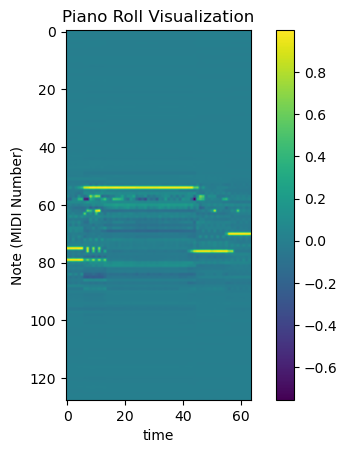

Epoch [34/50] Batch 100/990                   Loss D: -0.4915, loss G: -0.4953
Epoch [34/50] Batch 200/990                   Loss D: -0.6808, loss G: 0.0832
Epoch [34/50] Batch 300/990                   Loss D: -0.5752, loss G: -0.3419
Epoch [34/50] Batch 400/990                   Loss D: -0.5732, loss G: -1.1187
Epoch [34/50] Batch 500/990                   Loss D: -0.5236, loss G: -0.2742
Epoch [34/50] Batch 600/990                   Loss D: -0.5586, loss G: -1.1347
Epoch [34/50] Batch 700/990                   Loss D: -0.4349, loss G: 0.2834
Epoch [34/50] Batch 800/990                   Loss D: -0.6327, loss G: 0.1164
Epoch [34/50] Batch 900/990                   Loss D: -0.4742, loss G: -0.3521


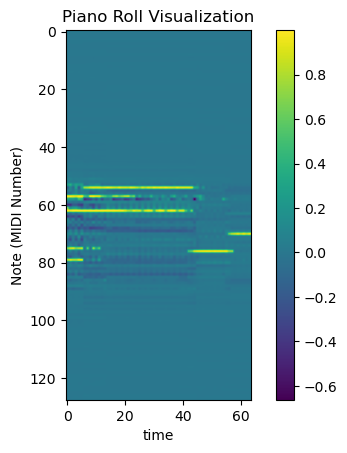

Epoch [35/50] Batch 100/990                   Loss D: -0.6599, loss G: -1.2129
Epoch [35/50] Batch 200/990                   Loss D: -0.7051, loss G: -1.0053
Epoch [35/50] Batch 300/990                   Loss D: -0.5025, loss G: -0.3067
Epoch [35/50] Batch 400/990                   Loss D: -0.5084, loss G: -0.2879
Epoch [35/50] Batch 500/990                   Loss D: -0.6880, loss G: -0.1277
Epoch [35/50] Batch 600/990                   Loss D: -0.4092, loss G: 0.5143
Epoch [35/50] Batch 700/990                   Loss D: -0.4947, loss G: -0.5061
Epoch [35/50] Batch 800/990                   Loss D: -0.3065, loss G: 0.0805
Epoch [35/50] Batch 900/990                   Loss D: -0.6944, loss G: -1.3325


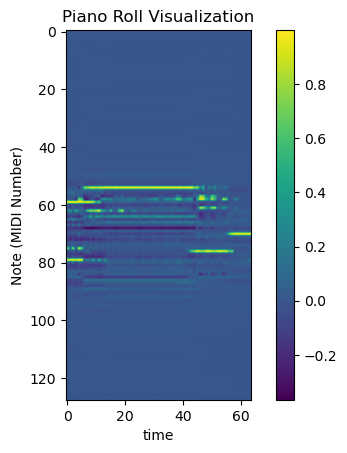

Epoch [36/50] Batch 100/990                   Loss D: -0.6347, loss G: 0.1785
Epoch [36/50] Batch 200/990                   Loss D: -0.5318, loss G: -0.0866
Epoch [36/50] Batch 300/990                   Loss D: -0.4419, loss G: 0.0263
Epoch [36/50] Batch 400/990                   Loss D: -0.5513, loss G: 0.0590
Epoch [36/50] Batch 500/990                   Loss D: -0.5323, loss G: 0.0975
Epoch [36/50] Batch 600/990                   Loss D: -0.5193, loss G: 0.0802
Epoch [36/50] Batch 700/990                   Loss D: -0.6044, loss G: 0.1651
Epoch [36/50] Batch 800/990                   Loss D: -0.6491, loss G: 0.4374
Epoch [36/50] Batch 900/990                   Loss D: -0.5511, loss G: 0.6250


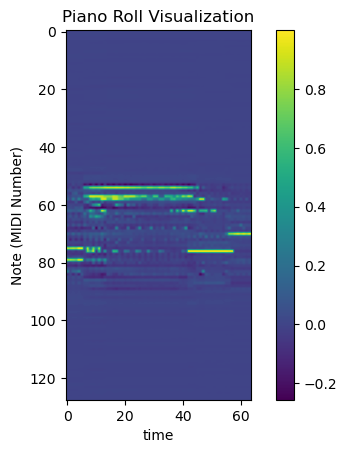

Epoch [37/50] Batch 100/990                   Loss D: -0.7003, loss G: -1.1832
Epoch [37/50] Batch 200/990                   Loss D: -0.6946, loss G: -1.4065
Epoch [37/50] Batch 300/990                   Loss D: -0.6386, loss G: -0.2413
Epoch [37/50] Batch 400/990                   Loss D: -0.6134, loss G: -0.8621
Epoch [37/50] Batch 500/990                   Loss D: -0.7438, loss G: -0.0272
Epoch [37/50] Batch 600/990                   Loss D: -0.6833, loss G: -0.7849
Epoch [37/50] Batch 700/990                   Loss D: -0.6020, loss G: 0.2848
Epoch [37/50] Batch 800/990                   Loss D: -0.6460, loss G: -0.1477
Epoch [37/50] Batch 900/990                   Loss D: -0.6406, loss G: 0.0180


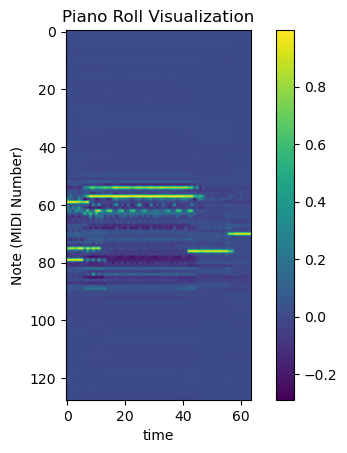

Epoch [38/50] Batch 100/990                   Loss D: -0.4863, loss G: -0.0056
Epoch [38/50] Batch 200/990                   Loss D: -0.6595, loss G: -1.0048
Epoch [38/50] Batch 300/990                   Loss D: -0.6023, loss G: 0.9161
Epoch [38/50] Batch 400/990                   Loss D: -0.6394, loss G: -0.6453
Epoch [38/50] Batch 500/990                   Loss D: -0.5773, loss G: -0.2145
Epoch [38/50] Batch 600/990                   Loss D: -0.5598, loss G: 0.0354
Epoch [38/50] Batch 700/990                   Loss D: -0.6848, loss G: 1.1819
Epoch [38/50] Batch 800/990                   Loss D: -0.7393, loss G: -0.4317
Epoch [38/50] Batch 900/990                   Loss D: -0.6931, loss G: -0.3830


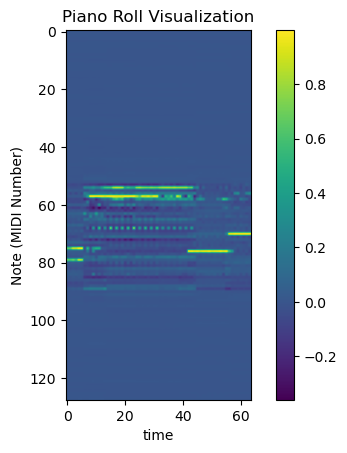

Epoch [39/50] Batch 100/990                   Loss D: -0.6700, loss G: -0.1428
Epoch [39/50] Batch 200/990                   Loss D: -0.6111, loss G: -0.8687
Epoch [39/50] Batch 300/990                   Loss D: -0.5292, loss G: -1.1298
Epoch [39/50] Batch 400/990                   Loss D: -0.5338, loss G: 0.1026
Epoch [39/50] Batch 500/990                   Loss D: -0.5570, loss G: -0.3830
Epoch [39/50] Batch 600/990                   Loss D: -0.7083, loss G: 0.9143
Epoch [39/50] Batch 700/990                   Loss D: -0.6156, loss G: -0.4706
Epoch [39/50] Batch 800/990                   Loss D: -0.5693, loss G: -1.0323
Epoch [39/50] Batch 900/990                   Loss D: -0.5821, loss G: -1.3430


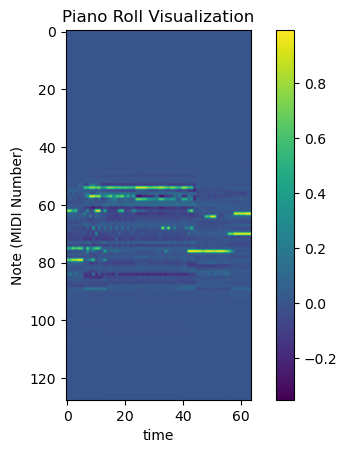

Epoch [40/50] Batch 100/990                   Loss D: -0.4790, loss G: -0.5326
Epoch [40/50] Batch 200/990                   Loss D: -0.6578, loss G: 1.3127
Epoch [40/50] Batch 300/990                   Loss D: -0.7527, loss G: -0.5826
Epoch [40/50] Batch 400/990                   Loss D: -0.5481, loss G: -0.8520
Epoch [40/50] Batch 500/990                   Loss D: -0.5096, loss G: -0.4196
Epoch [40/50] Batch 600/990                   Loss D: -0.6033, loss G: -0.6463
Epoch [40/50] Batch 700/990                   Loss D: -0.5248, loss G: 0.1469
Epoch [40/50] Batch 800/990                   Loss D: -0.6323, loss G: 0.5775
Epoch [40/50] Batch 900/990                   Loss D: -0.4662, loss G: -0.7730


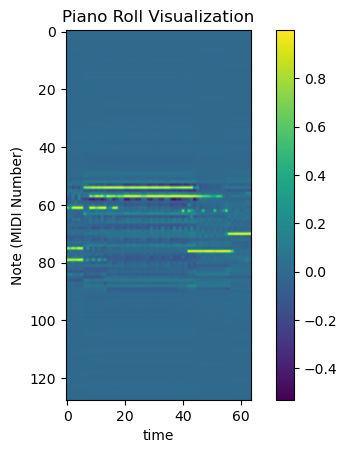

Epoch [41/50] Batch 100/990                   Loss D: -0.5617, loss G: 0.0399
Epoch [41/50] Batch 200/990                   Loss D: -0.4885, loss G: -0.5252
Epoch [41/50] Batch 300/990                   Loss D: -0.5965, loss G: 0.2778
Epoch [41/50] Batch 400/990                   Loss D: -0.6343, loss G: -0.1509
Epoch [41/50] Batch 500/990                   Loss D: -0.6440, loss G: -0.2877
Epoch [41/50] Batch 600/990                   Loss D: -0.4714, loss G: 0.1129
Epoch [41/50] Batch 700/990                   Loss D: -0.6207, loss G: -0.2758
Epoch [41/50] Batch 800/990                   Loss D: -0.5544, loss G: 0.0702
Epoch [41/50] Batch 900/990                   Loss D: -0.4162, loss G: 0.0633


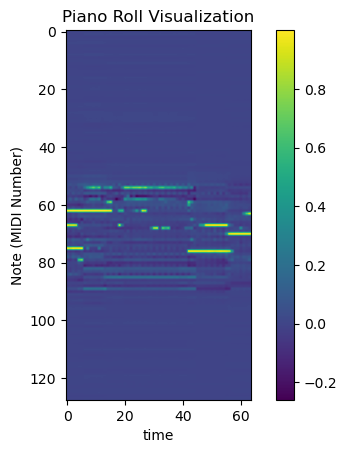

Epoch [42/50] Batch 100/990                   Loss D: -0.5164, loss G: 0.3364
Epoch [42/50] Batch 200/990                   Loss D: -0.6542, loss G: -0.8805
Epoch [42/50] Batch 300/990                   Loss D: -0.5583, loss G: 0.2399
Epoch [42/50] Batch 400/990                   Loss D: -0.5589, loss G: -0.5348
Epoch [42/50] Batch 500/990                   Loss D: -0.5900, loss G: -0.4499
Epoch [42/50] Batch 600/990                   Loss D: -0.7504, loss G: -0.7208
Epoch [42/50] Batch 700/990                   Loss D: -0.5241, loss G: -0.6484
Epoch [42/50] Batch 800/990                   Loss D: -0.8567, loss G: 0.8756
Epoch [42/50] Batch 900/990                   Loss D: -0.6519, loss G: 0.0419


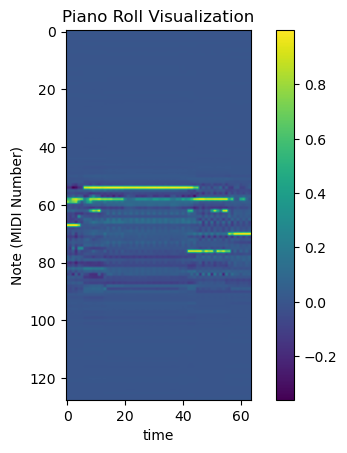

Epoch [43/50] Batch 100/990                   Loss D: -0.6913, loss G: -0.0141
Epoch [43/50] Batch 200/990                   Loss D: -0.6133, loss G: 0.5016
Epoch [43/50] Batch 300/990                   Loss D: -0.7556, loss G: 1.2427
Epoch [43/50] Batch 400/990                   Loss D: -0.6220, loss G: -0.7942
Epoch [43/50] Batch 500/990                   Loss D: -0.6194, loss G: 0.4782
Epoch [43/50] Batch 600/990                   Loss D: -0.6450, loss G: -1.5128
Epoch [43/50] Batch 700/990                   Loss D: -0.5438, loss G: 0.1702
Epoch [43/50] Batch 800/990                   Loss D: -0.4567, loss G: 1.0018
Epoch [43/50] Batch 900/990                   Loss D: -0.4181, loss G: -0.3992


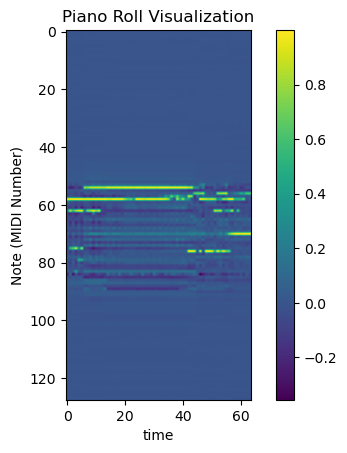

Epoch [44/50] Batch 100/990                   Loss D: -0.5504, loss G: -0.4912
Epoch [44/50] Batch 200/990                   Loss D: -0.5998, loss G: -0.5536
Epoch [44/50] Batch 300/990                   Loss D: -0.6178, loss G: 0.6873
Epoch [44/50] Batch 400/990                   Loss D: -0.5008, loss G: -0.0923
Epoch [44/50] Batch 500/990                   Loss D: -0.6137, loss G: -0.0456
Epoch [44/50] Batch 600/990                   Loss D: -0.4814, loss G: 0.0876
Epoch [44/50] Batch 700/990                   Loss D: -0.7079, loss G: -0.1220
Epoch [44/50] Batch 800/990                   Loss D: -0.6855, loss G: 0.5065
Epoch [44/50] Batch 900/990                   Loss D: -0.5810, loss G: 0.5561


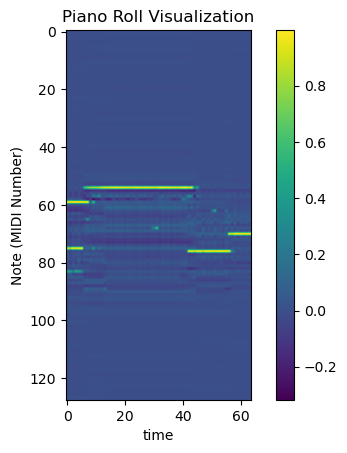

Epoch [45/50] Batch 100/990                   Loss D: -0.4074, loss G: 0.7349
Epoch [45/50] Batch 200/990                   Loss D: -0.6448, loss G: 0.4965
Epoch [45/50] Batch 300/990                   Loss D: -0.5805, loss G: -0.5298
Epoch [45/50] Batch 400/990                   Loss D: -0.4914, loss G: 0.5235
Epoch [45/50] Batch 500/990                   Loss D: -0.5060, loss G: 0.2098
Epoch [45/50] Batch 600/990                   Loss D: -0.4080, loss G: -0.0451
Epoch [45/50] Batch 700/990                   Loss D: -0.5689, loss G: -0.4142
Epoch [45/50] Batch 800/990                   Loss D: -0.6256, loss G: 0.0932
Epoch [45/50] Batch 900/990                   Loss D: -0.6372, loss G: 1.0095


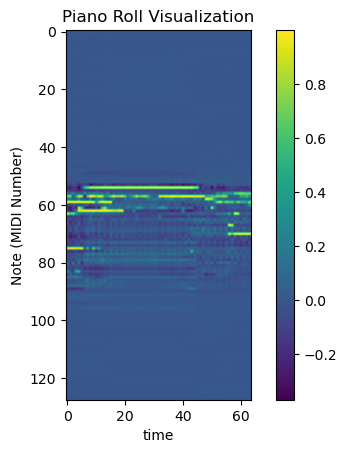

Epoch [46/50] Batch 100/990                   Loss D: -0.6962, loss G: -1.2463
Epoch [46/50] Batch 200/990                   Loss D: -0.6462, loss G: 0.8083
Epoch [46/50] Batch 300/990                   Loss D: -0.5399, loss G: 1.2421
Epoch [46/50] Batch 400/990                   Loss D: -0.4906, loss G: 0.0459
Epoch [46/50] Batch 500/990                   Loss D: -0.5040, loss G: 0.2018
Epoch [46/50] Batch 600/990                   Loss D: -0.4948, loss G: -0.8509
Epoch [46/50] Batch 700/990                   Loss D: -0.4527, loss G: 0.2880
Epoch [46/50] Batch 800/990                   Loss D: -0.5880, loss G: -0.3213
Epoch [46/50] Batch 900/990                   Loss D: -0.8915, loss G: 1.7901


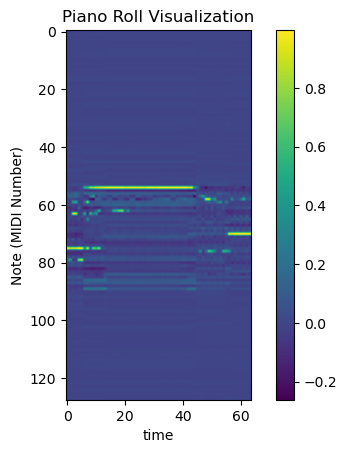

Epoch [47/50] Batch 100/990                   Loss D: -0.5272, loss G: -0.4332
Epoch [47/50] Batch 200/990                   Loss D: -0.6580, loss G: -0.7193
Epoch [47/50] Batch 300/990                   Loss D: -0.6177, loss G: -0.0543
Epoch [47/50] Batch 400/990                   Loss D: -0.5603, loss G: 0.0862
Epoch [47/50] Batch 500/990                   Loss D: -0.5099, loss G: 0.4721
Epoch [47/50] Batch 600/990                   Loss D: -0.5793, loss G: 0.5223
Epoch [47/50] Batch 700/990                   Loss D: -0.5385, loss G: -0.0970
Epoch [47/50] Batch 800/990                   Loss D: -0.5247, loss G: 0.7310
Epoch [47/50] Batch 900/990                   Loss D: -0.5940, loss G: 0.6331


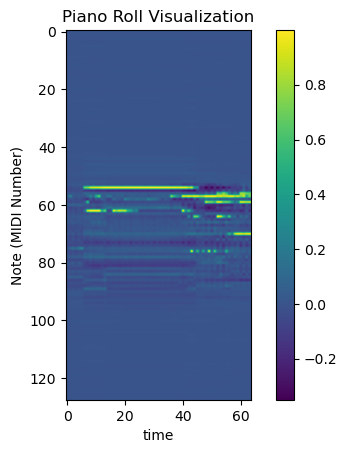

Epoch [48/50] Batch 100/990                   Loss D: -0.5731, loss G: 0.4230
Epoch [48/50] Batch 200/990                   Loss D: -0.5522, loss G: 0.5790
Epoch [48/50] Batch 300/990                   Loss D: -0.5656, loss G: -0.1450
Epoch [48/50] Batch 400/990                   Loss D: -0.5034, loss G: -1.4355
Epoch [48/50] Batch 500/990                   Loss D: -0.6786, loss G: -0.9003
Epoch [48/50] Batch 600/990                   Loss D: -0.5374, loss G: -0.4726
Epoch [48/50] Batch 700/990                   Loss D: -0.5989, loss G: -0.2802
Epoch [48/50] Batch 800/990                   Loss D: -0.4728, loss G: -0.1660
Epoch [48/50] Batch 900/990                   Loss D: -0.4234, loss G: 0.4941


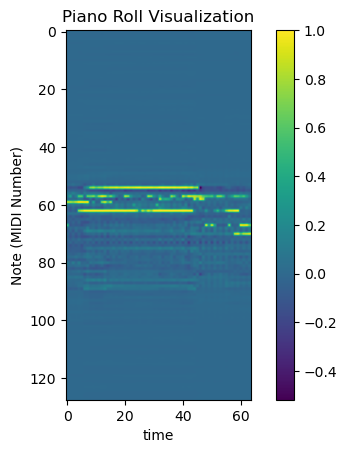

Epoch [49/50] Batch 100/990                   Loss D: -0.5921, loss G: -1.1413
Epoch [49/50] Batch 200/990                   Loss D: -0.5193, loss G: 0.3161
Epoch [49/50] Batch 300/990                   Loss D: -0.4203, loss G: 0.1837
Epoch [49/50] Batch 400/990                   Loss D: -0.5371, loss G: -0.5452
Epoch [49/50] Batch 500/990                   Loss D: -0.4153, loss G: -0.3289
Epoch [49/50] Batch 600/990                   Loss D: -0.7110, loss G: -0.4918
Epoch [49/50] Batch 700/990                   Loss D: -0.5758, loss G: -0.0188
Epoch [49/50] Batch 800/990                   Loss D: -0.5669, loss G: -0.6144
Epoch [49/50] Batch 900/990                   Loss D: -0.6564, loss G: 0.6192


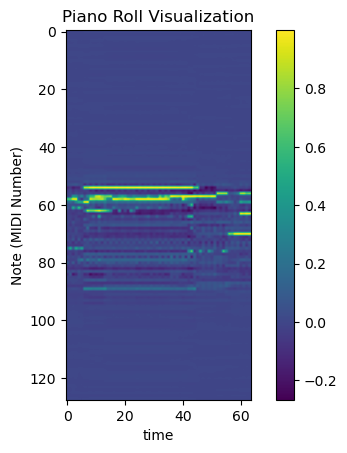

Training finished.


In [11]:

# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 72
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
pitch_range = 128

# for tensorboard plotting
fixed_noise = torch.randn(1, Z_DIM, device=device)

#writer_real = SummaryWriter(f"logs/GAN_MIDI/real")
#writer_fake = SummaryWriter(f"logs/GAN_MIDI/fake")

#step = 0

gen = Generator(nz=Z_DIM).to(device)
critic = Discriminator(pitch_range).to(device)

gen.apply(weights_init)
critic.apply(weights_init)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

gen.train()
critic.train()

fixed_prev = train_iter[67][0].unsqueeze(0).to(device)
print_piano_roll(train_iter[67][0].numpy().squeeze().transpose())

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (data,prev_data) in enumerate(train_loader, 0):
        real = data.to(device)
        prev_real = prev_data.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)
            fake = gen(noise,prev_real)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake.detach()).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(train_loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

    generate_and_save_images(gen,epoch + 1, noise[0].unsqueeze(0), fixed_prev)

            #with torch.no_grad():
                #fake = gen(fixed_noise, prev_real, BATCH_SIZE)
                # take out (up to) 32 examples
                #img_grid_real = vutils.make_grid(real[:32], normalize=True)
                #img_grid_fake = vutils.make_grid(fake[:32], normalize=True)

                #writer_real.add_image("Real", img_grid_real, global_step=step)
                #writer_fake.add_image("Fake", img_grid_fake, global_step=step)
                #writer_real.flush()
                #writer_fake.flush()

            #step += 1
print("Training finished.")

#writer_real.close()
#writer_fake.close()
# do checkpointing
torch.save(gen.state_dict(), 'netG_parameters.torch')
torch.save(critic.state_dict(), 'netD_parameters.torch')

In [19]:
def sample():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    netG = Generator(100)
    netG.load_state_dict(torch.load('netG_parameters.torch'))
    netG.to(device)

    netG.eval()

    random_sample_index = randrange(0, len(train_iter))
    priming_melody = train_iter[random_sample_index][0].unsqueeze(0).to(device)

    outputs = []
    for i in range(0,3):
        noise = torch.randn(1, Z_DIM).to(device)
        if i == 0:
            with torch.no_grad():
                bar = netG(noise,priming_melody)
                #outputs.append(netG(noise,priming_melody))
                print_piano_roll(bar.detach().cpu().numpy().squeeze().transpose())
                outputs.append(bar)
        else:
            with torch.no_grad():

                bin_output = (outputs[i - 1] > 0.6).float()
                bar = netG(noise,bin_output)
                #outputs.append(netG(noise,outputs[i - 1]))
                outputs.append(bar)
                print_piano_roll(bar.detach().cpu().numpy().squeeze().transpose())

    melody = [outputs[i].detach().cpu().numpy().squeeze().transpose() for i in range(len(outputs))]
    melody = np.stack(melody)
    melody = np.concatenate(melody, axis=1)

    return melody


In [16]:
def piano_roll_to_pretty_midi(piano_roll, fs, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.

    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.

    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.

    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

C:\Users\gabro\AppData\Local\Temp\ipykernel_45020\2939554833.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('netG_parameters.torch'))


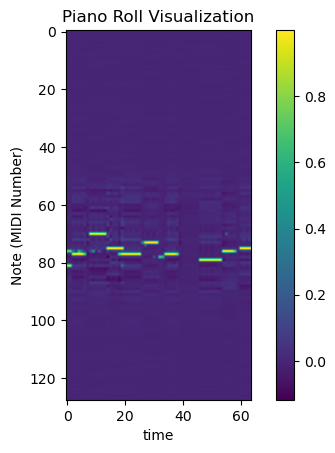

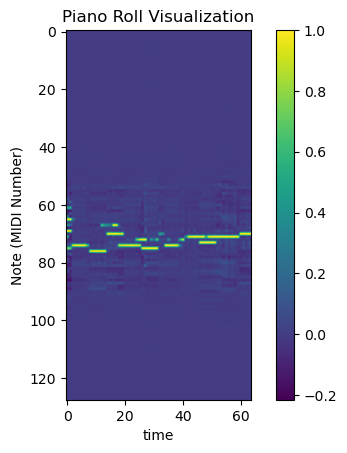

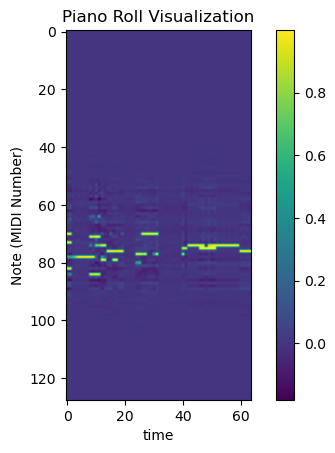

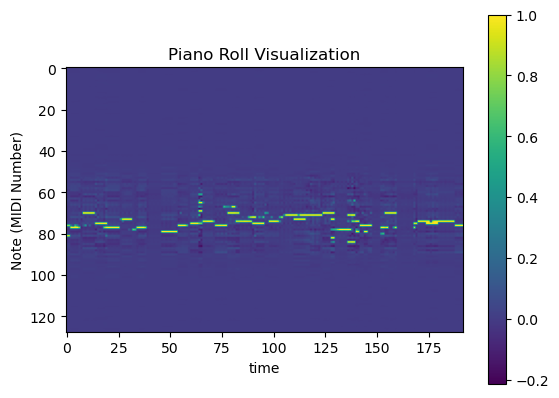

In [21]:
song = sample()

print_piano_roll(song)

song[song > 0.6] = 100

bpm = 190

sixtheen_note_per_sec = (bpm*16)/60
midi = piano_roll_to_pretty_midi(song, fs=sixtheen_note_per_sec, program=0)
midi.write('output.mid')
